Using device: cuda
DeepConvNet_A1(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (fc): Linear(in_features=256, out_features=100, bias=True)
)
[Epoch 1/100] Train Los

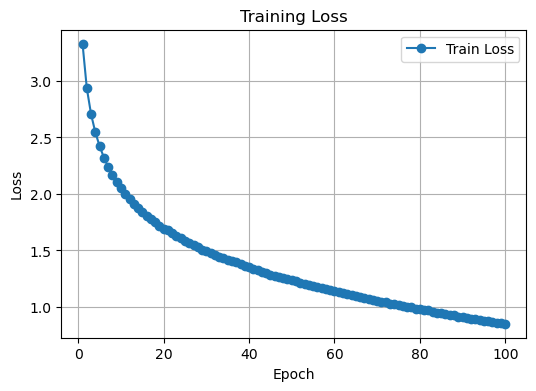

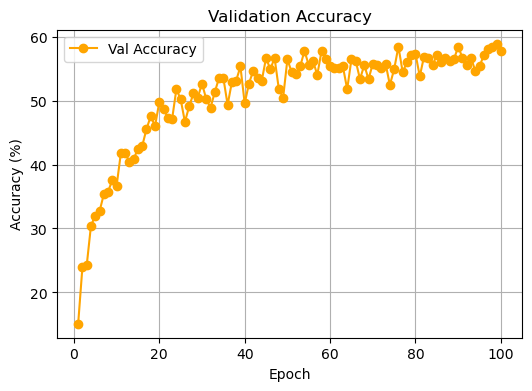


=== Final Results Table ===
| Method      | #Kernels   |   #Param (M) |   MAdds (M) |   Top-1 (%) |
|:------------|:-----------|-------------:|------------:|------------:|
| DeepConvNet | 多層卷積   |          0.4 |       275.6 |       58.22 |

Training history saved to 'metrics_history.csv' and final results saved to 'final_results.csv'.


In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from thop import profile
import pandas as pd

# -------------------------------
# 2. 設定運算裝置 (GPU / CPU)
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -------------------------------
# 3. 定義讀取 txt 檔案的函式 (讀取圖片路徑與標籤)
# -------------------------------
def load_dataset(txt_file):
    samples = []
    with open(txt_file, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 2:
                img_path, label = parts
                samples.append((img_path, int(label)))
    return samples

# -------------------------------
# 4. 自訂義 Dataset
# -------------------------------
class ImageDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        img_path, label = self.samples[index]
        # 讀取圖片並轉換為 RGB
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# -------------------------------
# 5. 設定影像前處理 (transforms)
# -------------------------------
transform_train = transforms.Compose([
    transforms.Resize((84, 84)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
transform_val_test = transforms.Compose([
    transforms.Resize((84, 84)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# -------------------------------
# 6. 讀取 train.txt, val.txt, test.txt
# -------------------------------
train_samples = load_dataset('train.txt')
val_samples = load_dataset('val.txt')
test_samples = load_dataset('test.txt')

train_dataset = ImageDataset(train_samples, transform=transform_train)
val_dataset = ImageDataset(val_samples, transform=transform_val_test)
test_dataset = ImageDataset(test_samples, transform=transform_val_test)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# -------------------------------
# 7. 定義修改後的卷積模型架構 (DeepConvNet)
# -------------------------------
# -------------------------------
# 7. 定義 A1 版本的卷積模型架構 (DeepConvNet_A1)
# -------------------------------
class DeepConvNet_A1(nn.Module):
    def __init__(self, num_classes=100):
        super(DeepConvNet_A1, self).__init__()
        # 第一層：3→64，84→42
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)
        )
        # 第二層：64→128，42→21
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)
        )
        # 第三層 layer3：128→256，21→1
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


model = DeepConvNet_A1(num_classes=100).to(device)
print(model)


# -------------------------------
# 8. 定義損失函式與優化器
# -------------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# -------------------------------
# 9. 定義訓練與評估函式
# -------------------------------
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(loader.dataset)
    return epoch_loss

def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    return correct / total

# -------------------------------
# 10. 主訓練迴圈，並記錄每個 epoch 的訓練 loss 與驗證準確率
# -------------------------------
num_epochs = 100  # 可依需求調整訓練次數
loss_history = []
val_acc_history = []

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    val_acc = evaluate(model, val_loader, device)
    loss_history.append(train_loss)
    val_acc_history.append(val_acc)
    print(f"[Epoch {epoch + 1}/{num_epochs}] Train Loss: {train_loss:.4f} | Val Acc: {val_acc * 100:.2f}%")

# -------------------------------
# 11. 在測試集上評估模型並取得最終準確率
# -------------------------------
test_acc = evaluate(model, test_loader, device)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# -------------------------------
# 12. 利用 thop 計算 FLOPs 與參數量
# -------------------------------
dummy_input = torch.randn(1, 3, 84, 84).to(device)
flops, params = profile(model, inputs=(dummy_input,), verbose=False)
print(f"FLOPs: {flops:,}  Params: {params:,}")

# -------------------------------
# 13. 繪製 Loss 與 Validation Accuracy 曲線
# -------------------------------
plt.figure(figsize=(6, 4))
plt.plot(range(1, num_epochs + 1), loss_history, marker='o', label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(range(1, num_epochs + 1), [x * 100 for x in val_acc_history], marker='o', color='orange', label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# -------------------------------
# 14. 將最終結果以類似論文中表格形式呈現，並存成 CSV 檔
# -------------------------------
method_name = "DeepConvNet"
num_kernels = "多層卷積"
madds = flops / 1e6  # FLOPs 換成 百萬次操作 (MAdds)
params_m = params / 1e6  # 參數量換算成 百萬參數 (M)
top1 = test_acc * 100

table_data = {
    "Method": [method_name],
    "#Kernels": [num_kernels],
    "#Param (M)": [f"{params_m:.2f}"],
    "MAdds (M)": [f"{madds:.2f}"],
    "Top-1 (%)": [f"{top1:.2f}"]
}

final_table = pd.DataFrame(table_data)
print("\n=== Final Results Table ===")
print(final_table.to_markdown(index=False))

final_table.to_csv("final_results.csv", index=False)

# -------------------------------
# 15. 將每個 epoch 的訓練歷史存成 CSV 檔 (例如 metrics_history.csv)
# -------------------------------
history_df = pd.DataFrame({
    "Epoch": list(range(1, num_epochs + 1)),
    "Train_Loss": loss_history,
    "Val_Acc (%)": [acc * 100 for acc in val_acc_history]
})
history_df.to_csv("metrics_history.csv", index=False)
print("\nTraining history saved to 'metrics_history.csv' and final results saved to 'final_results.csv'.")